In [1]:
# ============================================================================
# 1. SETUP AND CONFIGURATION
# ============================================================================

import os
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ============================================================================
# 2. KAGGLE CREDENTIALS SETUP
# ============================================================================

kaggle_creds = {
    "username": "yassineyahyaouii",  # Replace with your username
    "key": "6e0ebf67d37bb1c91dc21f7861a27c77"  # Replace with your API key
}

# Create .kaggle directory
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)

# Write credentials
kaggle_json_path = kaggle_dir / 'kaggle.json'
with open(kaggle_json_path, 'w') as f:
    json.dump(kaggle_creds, f)

# Set permissions
os.chmod(kaggle_json_path, 0o600)
print("✓ Kaggle credentials configured")

✓ Kaggle credentials configured


In [3]:
# ============================================================================
# 3. DOWNLOAD AND EXTRACT DATASET
# ============================================================================

# Download dataset
!kaggle datasets download -d maciejgronczynski/biggest-genderface-recognition-dataset

# Extract dataset
!unzip -q biggest-genderface-recognition-dataset.zip -d genderface_data
print("✓ Dataset downloaded and extracted")

Dataset URL: https://www.kaggle.com/datasets/maciejgronczynski/biggest-genderface-recognition-dataset
License(s): CC0-1.0
 92% 402M/439M [00:00<00:00, 426MB/s]
100% 439M/439M [00:00<00:00, 490MB/s]
✓ Dataset downloaded and extracted


In [4]:
# ============================================================================
# 4. EXPLORE DATASET STRUCTURE
# ============================================================================

def explore_dataset_structure():
    """Explore the GenderFace dataset structure"""
    base_path = Path('genderface_data')

    print("\n" + "="*60)
    print("EXPLORING DATASET STRUCTURE")
    print("="*60 + "\n")

    # Find all subdirectories
    for root, dirs, files in os.walk(base_path):
        level = root.replace(str(base_path), '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')

        # Show first few files in each directory
        subindent = ' ' * 2 * (level + 1)
        jpg_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if jpg_files:
            print(f'{subindent}[{len(jpg_files)} images]')
            if len(jpg_files) <= 5:
                for file in jpg_files[:5]:
                    print(f'{subindent}- {file}')

        if level > 2:  # Limit depth
            break

    print("\n" + "="*60 + "\n")

explore_dataset_structure()



EXPLORING DATASET STRUCTURE

genderface_data/
  faces/
    man/
      [17678 images]
    woman/
      [9489 images]




In [5]:
# ============================================================================
# 5. DATA ORGANIZATION
# ============================================================================

def organize_genderface_dataset():
    """
    Organize GenderFace dataset into train/val/test splits
    The dataset should already have male/female or man/woman folders
    """

    # Try to find the correct base path
    base_path = Path('genderface_data')

    # Common possible structures
    possible_paths = [
        base_path,
        base_path / 'faces',
        base_path / 'Training',
        base_path / 'train',
        base_path / 'data'
    ]

    # Find the path containing gender folders
    dataset_path = None
    for path in possible_paths:
        if path.exists():
            subdirs = [d.name.lower() for d in path.iterdir() if d.is_dir()]
            if any(gender in subdirs for gender in ['male', 'female', 'man', 'woman']):
                dataset_path = path
                break

    if dataset_path is None:
        # Search deeper
        for root, dirs, files in os.walk(base_path):
            dir_names = [d.lower() for d in dirs]
            if any(gender in dir_names for gender in ['male', 'female', 'man', 'woman']):
                dataset_path = Path(root)
                break

    if dataset_path is None:
        print("❌ Could not find gender folders. Please check the dataset structure.")
        return None

    print(f"✓ Found dataset at: {dataset_path}")

    # Map folder names to standardized names
    gender_mapping = {}
    for item in dataset_path.iterdir():
        if item.is_dir():
            name_lower = item.name.lower()
            if name_lower in ['male', 'man', 'men']:
                gender_mapping['male'] = item
            elif name_lower in ['female', 'woman', 'women']:
                gender_mapping['female'] = item

    if len(gender_mapping) != 2:
        print(f"❌ Expected 2 gender folders, found: {list(gender_mapping.keys())}")
        return None

    print(f"✓ Found gender folders: {list(gender_mapping.keys())}")

    # Count images
    male_images = list(gender_mapping['male'].rglob('*.jpg')) + \
                  list(gender_mapping['male'].rglob('*.jpeg')) + \
                  list(gender_mapping['male'].rglob('*.png'))
    female_images = list(gender_mapping['female'].rglob('*.jpg')) + \
                    list(gender_mapping['female'].rglob('*.jpeg')) + \
                    list(gender_mapping['female'].rglob('*.png'))

    print(f"\n✓ Dataset statistics:")
    print(f"  - Male images: {len(male_images)}")
    print(f"  - Female images: {len(female_images)}")
    print(f"  - Total images: {len(male_images) + len(female_images)}")

    return gender_mapping

gender_folders = organize_genderface_dataset()

✓ Found dataset at: genderface_data/faces
✓ Found gender folders: ['male', 'female']

✓ Dataset statistics:
  - Male images: 17678
  - Female images: 9489
  - Total images: 27167


In [6]:
# ============================================================================
# 6. TRAIN/VAL/TEST SPLIT
# ============================================================================

def create_splits(gender_folders, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split data into train/val/test sets"""

    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    split_dir = Path('genderface_splits')
    if split_dir.exists():
        shutil.rmtree(split_dir)
    split_dir.mkdir(exist_ok=True)

    for split in ['train', 'val', 'test']:
        for gender in ['male', 'female']:
            (split_dir / split / gender).mkdir(parents=True, exist_ok=True)

    print("\n" + "="*60)
    print("CREATING DATA SPLITS")
    print("="*60 + "\n")

    # Process each gender
    for gender in ['male', 'female']:
        source_dir = gender_folders[gender]

        # Get all images
        images = list(source_dir.rglob('*.jpg')) + \
                 list(source_dir.rglob('*.jpeg')) + \
                 list(source_dir.rglob('*.png'))

        if len(images) == 0:
            print(f"⚠ WARNING: No images found for {gender}")
            continue

        print(f"Processing {gender}: {len(images)} images")

        # Split data
        train_imgs, temp_imgs = train_test_split(
            images, train_size=train_ratio, random_state=42
        )
        val_imgs, test_imgs = train_test_split(
            temp_imgs,
            train_size=val_ratio/(val_ratio+test_ratio),
            random_state=42
        )

        # Copy files with progress bar
        for img_list, split in [(train_imgs, 'train'), (val_imgs, 'val'), (test_imgs, 'test')]:
            for img in tqdm(img_list, desc=f'Copying {gender} to {split}', leave=False):
                target = split_dir / split / gender / img.name
                # Handle duplicate names
                counter = 1
                while target.exists():
                    target = split_dir / split / gender / f"{img.stem}_{counter}{img.suffix}"
                    counter += 1
                shutil.copy2(img, target)

        print(f"  ✓ {gender.capitalize()}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")

    print("\n✓ Data split completed\n")
    return split_dir

split_dir = create_splits(gender_folders)



CREATING DATA SPLITS

Processing male: 17678 images


Copying male to train:   0%|          | 0/12374 [00:00<?, ?it/s]

Copying male to val:   0%|          | 0/2652 [00:00<?, ?it/s]

Copying male to test:   0%|          | 0/2652 [00:00<?, ?it/s]

  ✓ Male: 12374 train, 2652 val, 2652 test
Processing female: 9489 images


Copying female to train:   0%|          | 0/6642 [00:00<?, ?it/s]

Copying female to val:   0%|          | 0/1423 [00:00<?, ?it/s]

Copying female to test:   0%|          | 0/1424 [00:00<?, ?it/s]

  ✓ Female: 6642 train, 1423 val, 1424 test

✓ Data split completed



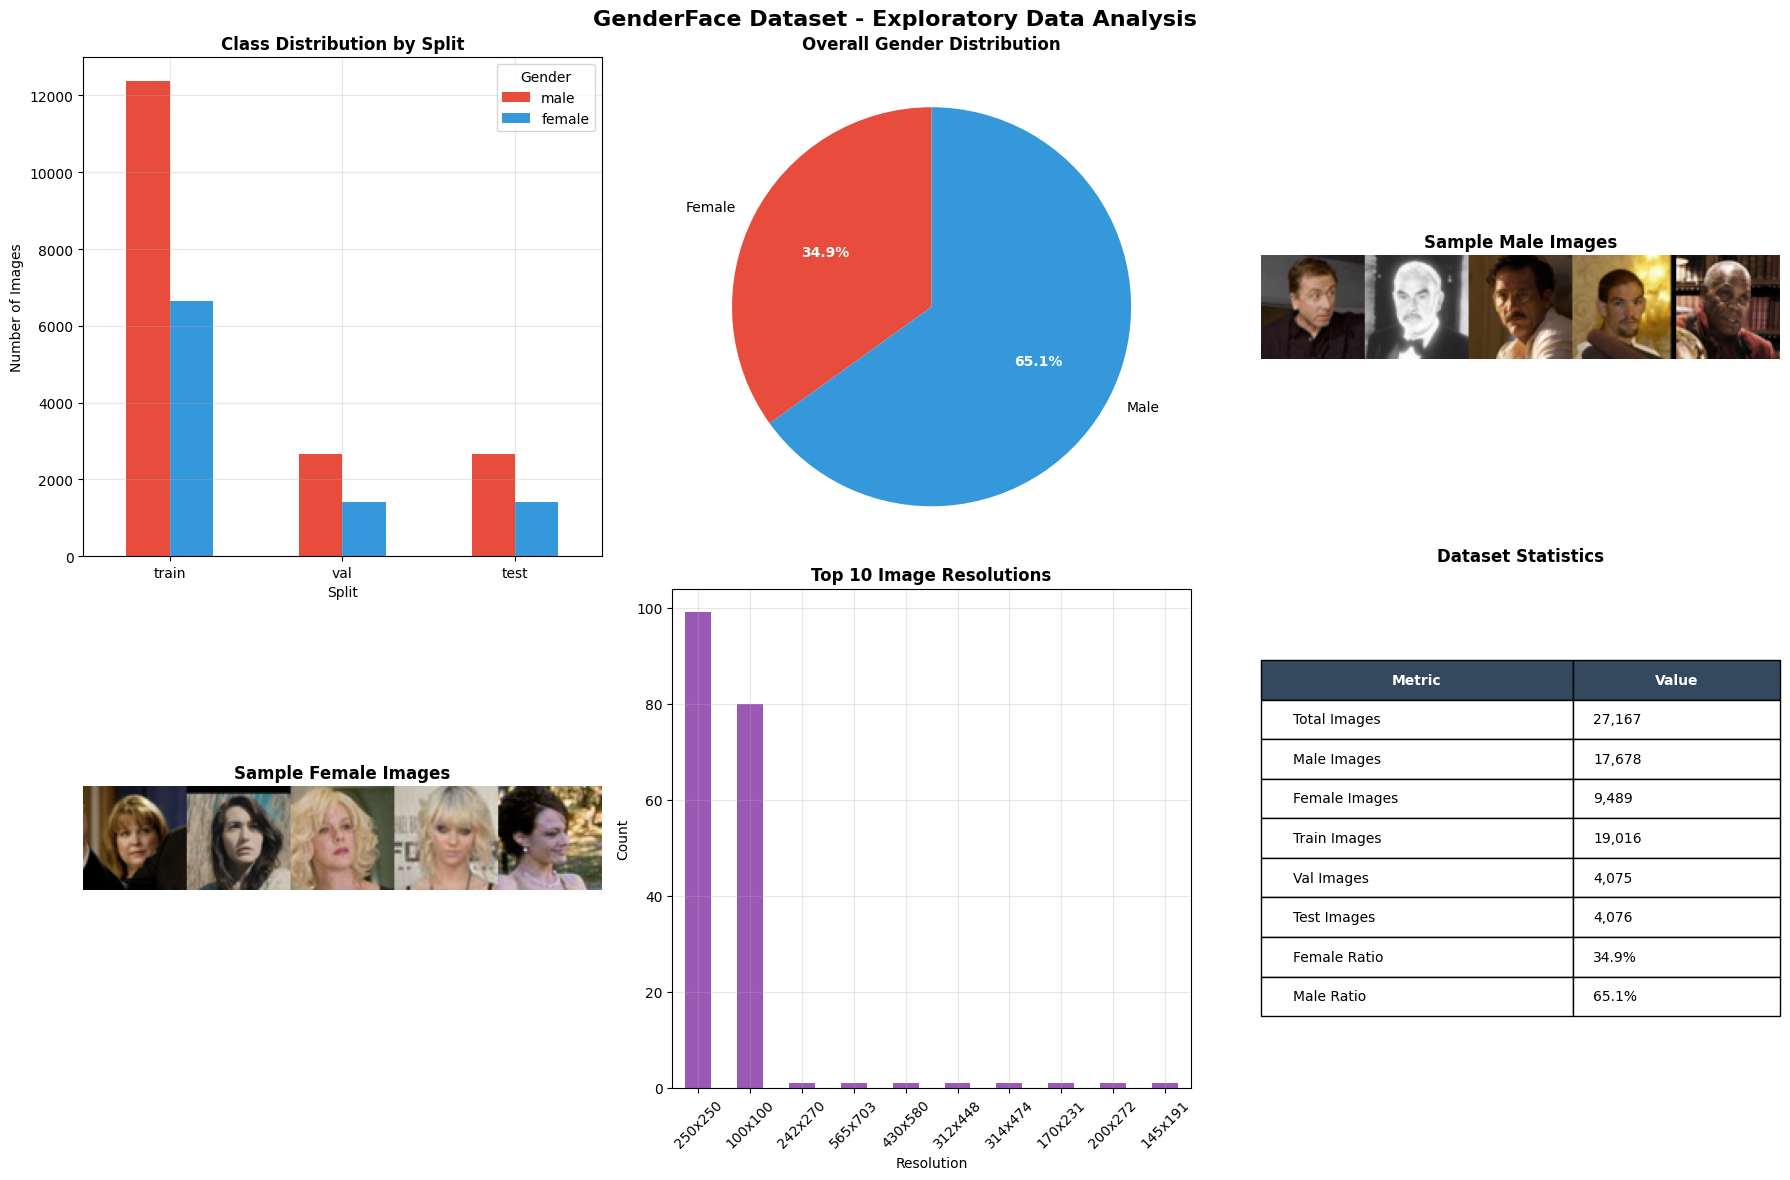

✓ EDA completed and saved to 'genderface_eda_analysis.png'


In [7]:
# ============================================================================
# 7. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

def perform_eda(split_dir):
    """Perform comprehensive EDA"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GenderFace Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

    # 1. Class Distribution
    counts = {'train': {}, 'val': {}, 'test': {}}
    for split in ['train', 'val', 'test']:
        for gender in ['male', 'female']:
            count = len(list((split_dir / split / gender).glob('*.jpg'))) + \
                    len(list((split_dir / split / gender).glob('*.jpeg'))) + \
                    len(list((split_dir / split / gender).glob('*.png')))
            counts[split][gender] = count

    # Plot class distribution
    ax = axes[0, 0]
    df_counts = pd.DataFrame(counts).T
    df_counts.plot(kind='bar', ax=ax, color=['#e74c3c', '#3498db'])
    ax.set_title('Class Distribution by Split', fontsize=12, fontweight='bold')
    ax.set_xlabel('Split')
    ax.set_ylabel('Number of Images')
    ax.legend(title='Gender')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

    # 2. Overall class balance
    ax = axes[0, 1]
    total_male = sum(counts[s]['male'] for s in counts)
    total_female = sum(counts[s]['female'] for s in counts)
    colors = ['#e74c3c', '#3498db']
    wedges, texts, autotexts = ax.pie([total_female, total_male],
                                       labels=['Female', 'Male'],
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax.set_title('Overall Gender Distribution', fontsize=12, fontweight='bold')

    # 3. Sample images - Male
    ax = axes[0, 2]
    male_imgs = list((split_dir / 'train' / 'male').glob('*.jpg'))[:5]
    if not male_imgs:
        male_imgs = list((split_dir / 'train' / 'male').glob('*.png'))[:5]
    if male_imgs:
        combined = np.hstack([np.array(Image.open(img).resize((64, 64))) for img in male_imgs[:5]])
        ax.imshow(combined)
        ax.set_title('Sample Male Images', fontsize=12, fontweight='bold')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No male images', ha='center', va='center')
        ax.axis('off')

    # 4. Sample images - Female
    ax = axes[1, 0]
    female_imgs = list((split_dir / 'train' / 'female').glob('*.jpg'))[:5]
    if not female_imgs:
        female_imgs = list((split_dir / 'train' / 'female').glob('*.png'))[:5]
    if female_imgs:
        combined = np.hstack([np.array(Image.open(img).resize((64, 64))) for img in female_imgs[:5]])
        ax.imshow(combined)
        ax.set_title('Sample Female Images', fontsize=12, fontweight='bold')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No female images', ha='center', va='center')
        ax.axis('off')

    # 5. Image resolution analysis
    ax = axes[1, 1]
    resolutions = []
    for gender in ['male', 'female']:
        imgs = list((split_dir / 'train' / gender).glob('*.jpg'))[:100]
        if not imgs:
            imgs = list((split_dir / 'train' / gender).glob('*.png'))[:100]
        for img_path in imgs:
            try:
                img = Image.open(img_path)
                resolutions.append(f"{img.size[0]}x{img.size[1]}")
            except:
                continue

    if resolutions:
        res_counts = pd.Series(resolutions).value_counts().head(10)
        res_counts.plot(kind='bar', ax=ax, color='#9b59b6')
        ax.set_title('Top 10 Image Resolutions', fontsize=12, fontweight='bold')
        ax.set_xlabel('Resolution')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

    # 6. Statistics table
    ax = axes[1, 2]
    ax.axis('off')
    total_images = total_male + total_female
    stats_data = [
        ['Total Images', f"{total_images:,}"],
        ['Male Images', f"{total_male:,}"],
        ['Female Images', f"{total_female:,}"],
        ['Train Images', f"{sum(counts['train'].values()):,}"],
        ['Val Images', f"{sum(counts['val'].values()):,}"],
        ['Test Images', f"{sum(counts['test'].values()):,}"],
        ['Female Ratio', f"{(total_female/total_images)*100:.1f}%"],
        ['Male Ratio', f"{(total_male/total_images)*100:.1f}%"]
    ]
    table = ax.table(cellText=stats_data, colLabels=['Metric', 'Value'],
                     cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    for i in range(2):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    ax.set_title('Dataset Statistics', fontsize=12, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('genderface_eda_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ EDA completed and saved to 'genderface_eda_analysis.png'")

perform_eda(split_dir)


In [8]:
# ============================================================================
# 8. DATASET AND DATALOADER
# ============================================================================

class GenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        # female=0, male=1
        for gender_idx, gender in enumerate(['female', 'male']):
            gender_dir = self.root_dir / gender
            if not gender_dir.exists():
                continue

            # Support multiple image formats
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                for img_path in gender_dir.glob(ext):
                    self.samples.append((str(img_path), gender_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), color='black')

        if self.transform:
            image = self.transform(image)

        return image, label

# Data transforms with stronger augmentation for larger dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = GenderDataset(split_dir / 'train', transform=train_transform)
val_dataset = GenderDataset(split_dir / 'val', transform=test_transform)
test_dataset = GenderDataset(split_dir / 'test', transform=test_transform)

print(f"\n✓ Datasets created:")
print(f"  - Train: {len(train_dataset)} samples")
print(f"  - Val: {len(val_dataset)} samples")
print(f"  - Test: {len(test_dataset)} samples")

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)


✓ Datasets created:
  - Train: 19016 samples
  - Val: 4075 samples
  - Test: 4076 samples


In [9]:
# ============================================================================
# 9. MODEL DEFINITION
# ============================================================================

class GenderClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(GenderClassifier, self).__init__()
        # Use ResNet18 as backbone
        self.backbone = models.resnet18(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        # Add dropout for regularization
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return self.backbone(x)

model = GenderClassifier(pretrained=True).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n✓ Model created (ResNet18)")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]



✓ Model created (ResNet18)
  - Total parameters: 11,308,354
  - Trainable parameters: 11,308,354


In [12]:
# ============================================================================
# 10. TRAINING
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                         'acc': f'{100.*correct/total:.2f}%'})

    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  patience=3, factor=0.5)

# Training loop
num_epochs = 3
best_val_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_genderface.pth')
        print(f"✓ Model saved (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%\n")



STARTING TRAINING


Epoch 1/3
----------------------------------------


Training:   0%|          | 0/595 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.2604 | Train Acc: 89.40%
Val Loss: 0.3805 | Val Acc: 84.83%
✓ Model saved (Val Acc: 84.83%)

Epoch 2/3
----------------------------------------


Training:   0%|          | 0/595 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.1973 | Train Acc: 92.49%
Val Loss: 0.1276 | Val Acc: 95.78%
✓ Model saved (Val Acc: 95.78%)

Epoch 3/3
----------------------------------------


Training:   0%|          | 0/595 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.1790 | Train Acc: 93.35%
Val Loss: 0.1840 | Val Acc: 92.88%

TRAINING COMPLETED
Best Validation Accuracy: 95.78%



In [13]:
# ============================================================================
# 11. EVALUATION
# ============================================================================

def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating', leave=False):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Load best model
model.load_state_dict(torch.load('best_model_genderface.pth'))
print("Evaluating on test set...")
test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device)

Evaluating on test set...


Evaluating:   0%|          | 0/128 [00:00<?, ?it/s]

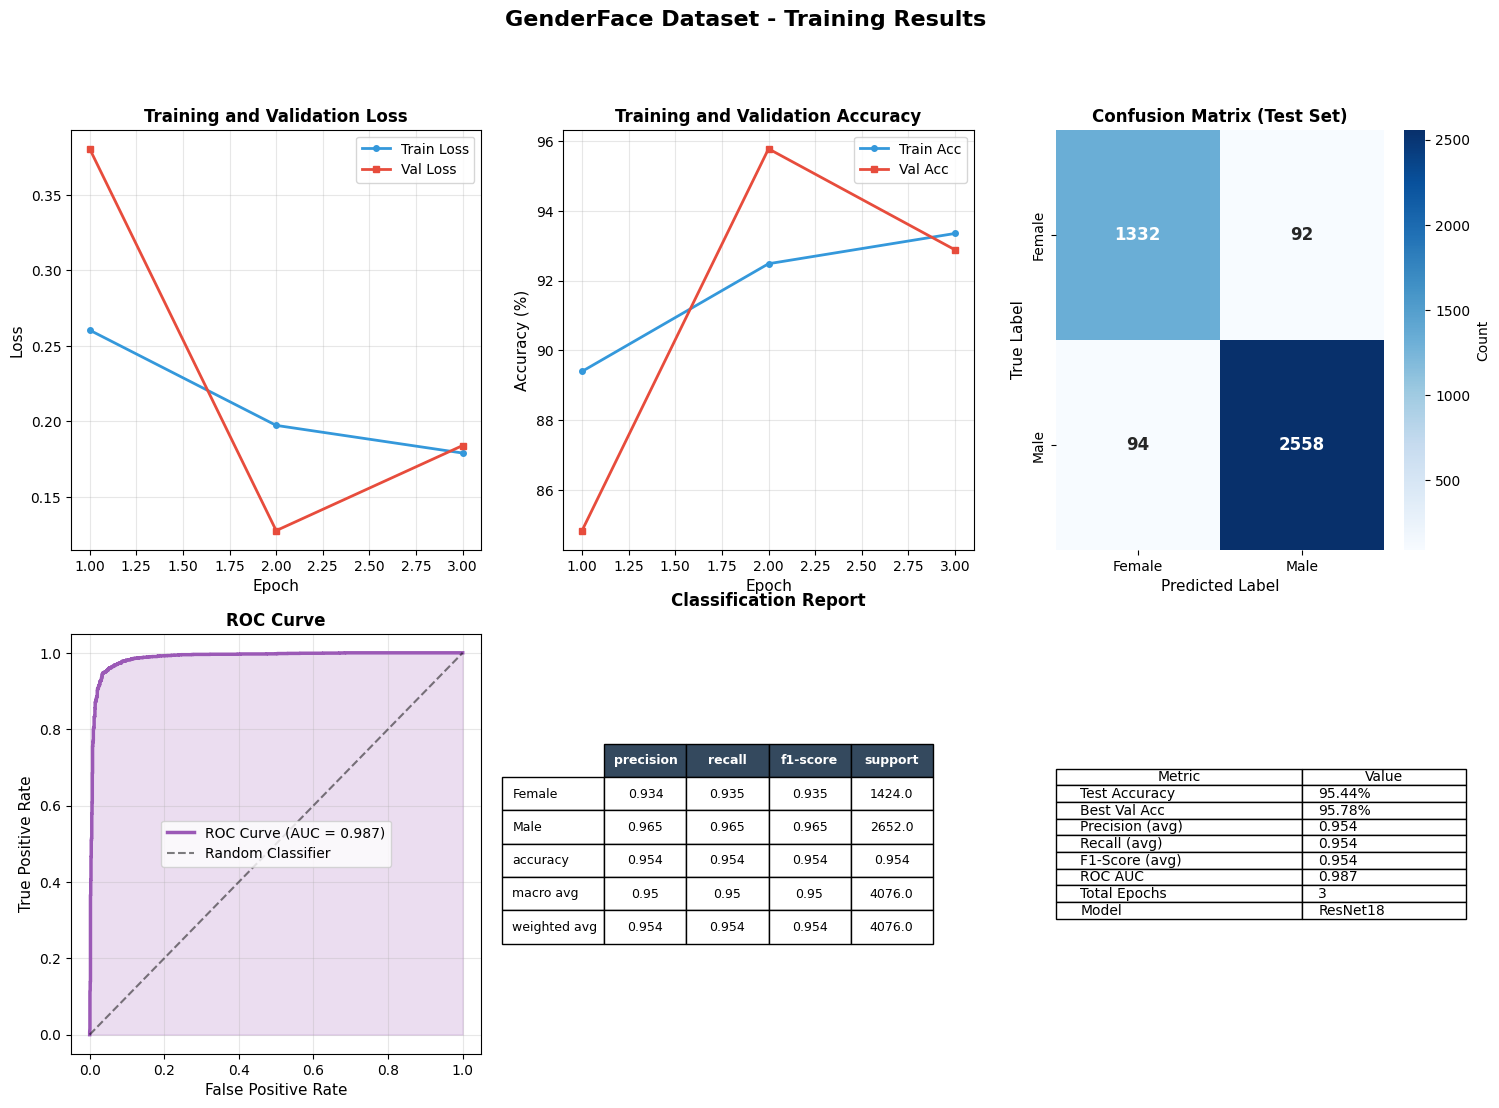

In [15]:
# ============================================================================
# 12. RESULTS VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('GenderFace Dataset - Training Results', fontsize=16, fontweight='bold')

# 1. Training and Validation Loss
ax = axes[0, 0]
epochs_range = range(1, len(history['train_loss']) + 1)
ax.plot(epochs_range, history['train_loss'], label='Train Loss', linewidth=2,
        color='#3498db', marker='o', markersize=4)
ax.plot(epochs_range, history['val_loss'], label='Val Loss', linewidth=2,
        color='#e74c3c', marker='s', markersize=4)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Training and Validation Accuracy
ax = axes[0, 1]
ax.plot(epochs_range, history['train_acc'], label='Train Acc', linewidth=2,
        color='#3498db', marker='o', markersize=4)
ax.plot(epochs_range, history['val_acc'], label='Val Acc', linewidth=2,
        color='#e74c3c', marker='s', markersize=4)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Confusion Matrix
ax = axes[0, 2]
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'],
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)

# 4. ROC Curve
ax = axes[1, 0]
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, linewidth=2.5, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='#9b59b6')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.5)
ax.fill_between(fpr, tpr, alpha=0.2, color='#9b59b6')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 5. Classification Report
ax = axes[1, 1]
ax.axis('off')
report = classification_report(test_labels, test_preds,
                               target_names=['Female', 'Male'],
                               output_dict=True)
report_df = pd.DataFrame(report).T.round(3)
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
table = ax.table(cellText=report_df.values, colLabels=report_df.columns,
                 rowLabels=report_df.index, cellLoc='center', loc='center',
                 colWidths=[0.2, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(len(report_df.columns)):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax.set_title('Classification Report', fontsize=12, fontweight='bold', pad=20)

# 6. Performance Metrics Summary
ax = axes[1, 2]
ax.axis('off')
test_acc = 100 * (test_preds == test_labels).mean()
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

metrics_data = [
    ['Test Accuracy', f'{test_acc:.2f}%'],
    ['Best Val Acc', f'{best_val_acc:.2f}%'],
    ['Precision (avg)', f'{precision:.3f}'],
    ['Recall (avg)', f'{recall:.3f}'],
    ['F1-Score (avg)', f'{f1:.3f}'],
    ['ROC AUC', f'{roc_auc:.3f}'],
    ['Total Epochs', str(num_epochs)],
    ['Model', 'ResNet18']
]
table = ax.table(cellText=metrics_data, colLabels=['Metric', 'Value'],
                 cellLoc='left', loc='center', colWidths=[0.6, 0.4])
